In [1]:
from urllib.parse import unquote
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# 楽曲リスト取得

In [2]:
def read_track_idomaar(filename = '/home/tamak/master_exp/entities/tracks.idomaar'):

    track_list = []

    with open( filename, mode = 'r' ) as f:
        for line in f.readlines():
            attribute, id, _, track_, artist_ = line.split('\t')
            if len(track_.split('"')) == 13:
                track_ = track_.split('"')[11].replace('+',' ')
            else:
                track_ = track_.split('"')[9].replace('+',' ')
            try:
                artist, track = unquote(track_).split('/_/')
            except:
                print('error')
                print(line.split('\t')[3].split('"'))
                print(line.split('\t'))
            
            track_list.append( (track , artist ) )
    
    return track_list

def track_to_id_30M(filename = '/home/tamak/master_exp/entities/tracks.idomaar'):

    track_ids = defaultdict(int)

    with open( filename, mode = 'r' ) as f:
        lines = f.readlines()

        for line in lines:
            attribute, id, _, track_, artist_ = line.split('\t')

            track = json.loads(track_)

            artistname, trackname = track['name'].replace('+',' ').split('/_/')
            artistname = unquote(artistname)
            trackname = unquote(trackname)

            track_ids[ (trackname,artistname) ] = int(id)

    return track_ids    

def get_track_spotify( filename = '/home/tamak/experiments/spotify_dataset_modified.tsv' ):

    track_list = []

    with open( filename, mode = 'r' ) as f:
        for line in f.readlines():
            user, artist, track, playlist = line.split('\t')
            track_list.append( (track,artist) )
    
    return list(set(track_list))

In [3]:
def shared_track_ids():
    track_30M = read_track_idomaar()
    track_SPD = get_track_spotify()

    shared_track = list(set(track_30M) & set(track_SPD))
    track_id = track_to_id_30M()

    tmp = []
    for track in shared_track:
        tmp.append(track_id[track])

    return tmp

In [4]:
share_track = shared_track_ids()

# 収集期間が~14/5/11のものに絞ってみる

In [25]:
filename = '/home/tamak/master_exp/relations/sessions.idomaar'

session_list = []

with open( filename, mode = 'r' ) as f:
    lines = f.readlines()
 
    for line in tqdm(lines):

        tmp = []

        obj_type, id, timestamp, session_data = line.split('\t')

        timestamp = int(timestamp)
        if timestamp >= 1399852800:
            continue

        analytics, session = session_data.split(' ')
        session = json.loads(session)

        if session.get('objects'):

            for track in session['objects']:
                id = track['id']
                tmp.append(id)

            session_list.append(tuple(tmp))
        
        else:
            print(session)

100%|██████████| 2764474/2764474 [00:10<00:00, 266152.80it/s]


In [26]:
print(len(session_list))
print(session_list[0])
print(len(set(session_list)))

715809
(4698874, 838286, 2588097, 2746740, 3873988, 808046, 2588498, 2492893, 2168413, 1778345, 2989691, 4698875, 2985955, 4698876, 1728736, 2615446, 4698877, 4698878, 515524, 4698879, 4698880, 2444241, 4698881)
661517


715809
11.969693032638595
484.03719221279704
[ 1.  1.  2.  6. 13. 27. 41.]


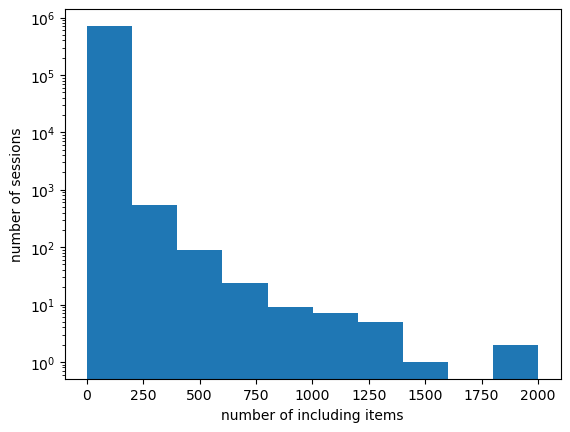

In [27]:
session_length = []

for session in session_list:
    session_length.append(len(session))

print(len(session_length))
print(np.average(session_length))
print(np.var(session_length))
print( np.percentile( session_length, [5, 10, 25, 50, 75, 90, 95] ) )

plt.figure()
plt.hist(session_length, log = True)
plt.xlabel('number of including items')
plt.ylabel('number of sessions')
plt.show()

41.0
10.159446298606873
74.56007408816605


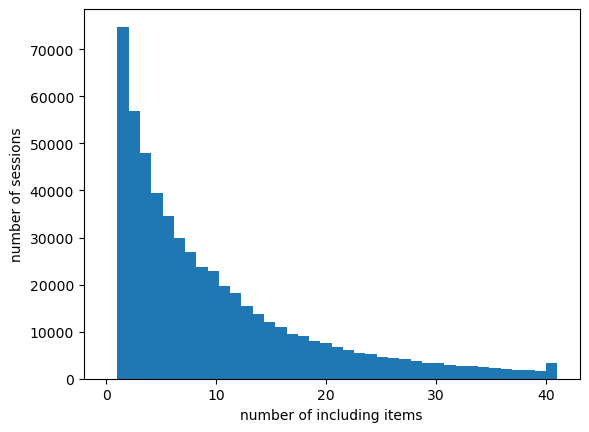

In [44]:
lim = np.percentile( session_length, 95 )
print(lim)
session_length2 = np.array(session_length)

print(np.average(session_length2[(1<session_length2) & (session_length2<=lim)]))
print(np.var(session_length2[(1<session_length2) & (session_length2<=lim)]))

plt.figure()
plt.hist(session_length2[(1<session_length2) & (session_length2<=lim)], bins = 40 , range = [0,lim], log = False)
plt.xlabel('number of including items')
plt.ylabel('number of sessions')
plt.show()

In [37]:
def calculate_match_ratios(session_list, item_list):
    item_set = set(item_list)  # 高速な検索のためにsetに変換
    match_ratios = []

    for session in tqdm(session_list):
        if not session:
            match_ratios.append(0.0)
            continue
        match_count = sum(1 for item in session if item in item_set)
        ratio = match_count / len(session)
        match_ratios.append(ratio)

    return match_ratios

lim = np.percentile( session_length, 95 )
print(lim)
session_length2 = np.array(session_length)
idxs = [ (1<session_length2) & (session_length2<=lim) ]

test = []
for i, idx in enumerate(idxs[0]):
    if idx == True:
        test.append(session_list[i])

41.0


In [38]:
np.average( session_length2[idxs[0]] )

10.159446298606873

In [40]:
print(len(test))
print(len(session_list))
print(len(session_length))
print(len(session_length2))
print(sum(idxs[0]))

552211
715809
715809
715809
552211


In [41]:
shared_rates = calculate_match_ratios(test, share_track)

100%|██████████| 552211/552211 [00:01<00:00, 504286.57it/s]


In [45]:
len(shared_rates)

552211

In [42]:
shared_rates[:10]

[0.5217391304347826,
 0.5454545454545454,
 0.75,
 0.2,
 0.625,
 0.0,
 1.0,
 0.4444444444444444,
 0.9090909090909091,
 0.75]

0.6072211201133905
0.1279952874024304
[0.         0.         0.33333333 0.68181818 0.96153846 1.
 1.        ]


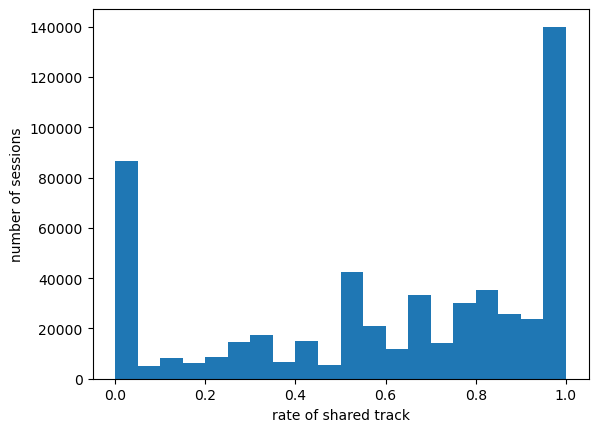

In [ ]:
print(np.average(shared_rates))
print(np.var(shared_rates))
print( np.percentile( shared_rates, [5, 10, 25, 50, 75, 90, 95] ) )

plt.figure()
plt.hist(shared_rates, log = False, bins = 20)
plt.xlabel('rate of shared track')
plt.ylabel('number of sessions')
plt.show()